In [1]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay
from casadi import *

from utils import get_trajectory, get_position, my_odometry, get_interpolation, get_angles, get_acceleration

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [4]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.28], 0]

/home/giulio/prog/duckrace_simulator/utils.py:219: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


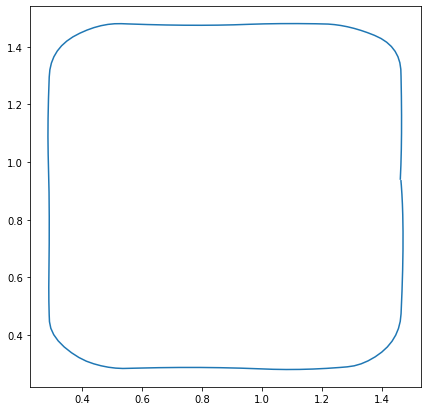

In [6]:
env.reset()
traj = get_trajectory(env, samples=200)
plt.plot(*traj.T)

In [7]:
pose = get_position(env)
pose

Position(x=0.7019999027252197, y=1.4749999999999999, theta=0)

In [8]:
spline_x, spline_y, _, _, x_origin, y_origin = get_interpolation(env, return_origin=True)

In [9]:
# Hyperparameters
test_results = True
T = 10 # Time horizon
N = 20 # Number of control intervals

In [10]:
def mpc_loss(u, N, x0, y0, theta0, v0, w0, Q, R, dt, last_actions):
    """
    L(u) = sum_{t=0}^{N-1} Q * ||x_o_t - x_t||^2 + R * ||u_t||^2
    """
    u = u.reshape(-1, 2)
    u = np.concatenate(([[0, 0]], last_actions, u))
    loss = 0
    for t in range(1, N-1):
        p, v0, w0 = my_odometry(u[t], x0, y0, theta0, v0, w0, dt=dt)
        angle = get_angles([p.x], [p.y], x_origin, y_origin)
        x, y = spline_x(angle), spline_y(angle)
        loss += Q[t] * ((p.x - x)**2 + (p.y - y)**2)*1e-3 + R * ((u[t][0]-u[t-1][0])**2 + (u[t][1]-u[t-1][1])**2) #- R * ((u[t][0])**2 + (u[t][1])**2)
        x0, y0, theta0 = p.x, p.y, p.theta

    return loss


Initialize states, inputs, and system dynamic equation

In [11]:
dt = 1.0 / env.frame_rate

In [12]:
u1 = 5
w1 = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [ ]:
# # States
# x0 = MX.sym('x')
# y0 = MX.sym('y')
# th0 = MX.sym('th')
# v0 = MX.sym('v')
# w0 = MX.sym('w')
# x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# # Inputs
# wl = MX.sym('wl')
# wr = MX.sym('wr')
# u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# # System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
# x_dot_dot = x_long_dot_dot*cos(th0)
# y_dot_dot = x_long_dot_dot*sin(th0)
# ode = vertcat(x_long_dot_dot, w_dot_dot, x_dot_dot, y_dot_dot) # ORDINARY DIFFERENTIAL EQUATION: Always vertically concatenate dynamic equations --> [n_x,1]
# f = Function('f',[x,u],[ode],['x','u'],['ode'])
# if test_results:
#     print(f([0.702, 1.344706, 0, 0, 0], [1, 1]))

[3, 0, 3, 0]


Directly dae?

In [13]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = v0 + x_long_dot_dot*dt
w1 = w0 + w_dot_dot*dt
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([0.702, 1.344706, 0, 0, 0], [1, 1]))

[0.702, 1.34471, 0, 0.1, 0]


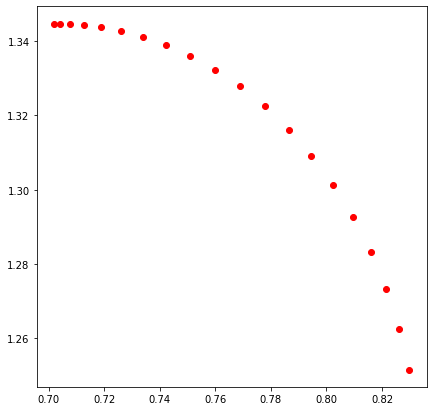

In [26]:
# Test the problem definition
sim = F.mapaccum(N) # To call the F function N times
x0 = [0.702, 1.344706, 0, 0, 0]
res = sim(x0, [1, 0.2]) # Example: u1 = cosine excitation
fig = plt.figure()
tgrid = np.linspace(0,T,N+1)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'ro')

In [22]:
res[0,:]

DM([[0.702, 0.705333, 0.711444, 0.71987, 0.730225, 0.742188, 0.75549, 0.769908, 0.785257, 0.801381, 0.818151, 0.835459, 0.853216, 0.871346, 0.889789, 0.908491, 0.927409, 0.946507, 0.965756, 0.98513]])

In [16]:
sim

Function(mapaccum_F:(x[5],u[2x20])->(dae[5x20]) MXFunction)

In [181]:
from scipy.sparse import csc_matrix
U = MX.sym('U',1,N)
X1 = sim(x0,U)[0,:]
J = jacobian(X1,U)

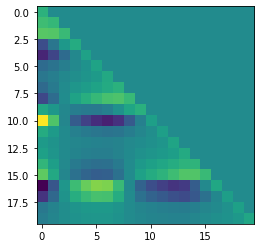

In [182]:
Jf = Function('Jf',[U],[J])
plt.imshow(Jf(0))

MESSAGE(sqpmethod): Convergence achieved after 4 iterations


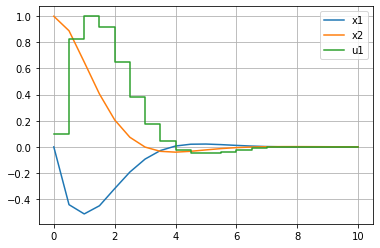

In [30]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(2,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(1,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(2,1)     # Parameter to set the initial state conditions (x(0))

obj = sumsqr(x)+sumsqr(u)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # System dynamics is called through F, that we defined above as the DAE that maps (x,u) --> (x,next)
    
# 2) Additional states/inputs constraints 
opti.subject_to(u<=1)        
opti.subject_to(u>=-1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0]==p)

opti.set_value(p,[0, 1]) # Set the initial x0 value

# Set additional options
opts = dict()
opts["qpsol"] = "qrqp" # Solver! See the docs for information
opts["print_header"] = False
opts["print_iteration"] = False
opts["print_time"] = False
opts["qpsol_options"] = dict({"print_iter":False,"print_header":False,"print_info":False})
opti.solver("sqpmethod", opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve() # For testing purpose: test the optimization on 1 time step
    fig = plt.figure
    plt.plot(tgrid, sol.value(x[0,:]).T, label='x1')
    plt.plot(tgrid, sol.value(x[1,:]).T, label='x2')
    plt.plot(tgrid, np.column_stack((sol.value(u).reshape(1,-1), np.NaN)).T, drawstyle='steps-post', label='u1')
    plt.grid(True)
    plt.legend()

Final Step: run the MPC control loop!
N.B. Given that we want to simulate the system, e.g., 50 timesteps,
1. at each time step the previosly defined optimization problem computes inputs u and predicted states x in the prediction horizon N.
2. from computed sequence of inputs (u(0), ..., u(T)), ONLY u(0) value is selected to simulate the system
3. (x0, u(0)) --> x_next == x(1)
4. the loop restart

In [32]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p],[u[:,0]],['p'],['u_opt'])

In [33]:
# MPC loop
X_log = np.empty((2,0))
U_log = np.array([])

x = [0,1]
for i in range(4*N):
    u = M(x)

    U_log = np.append(U_log, u)
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u) + [0, np.random.rand()*0.02]

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved

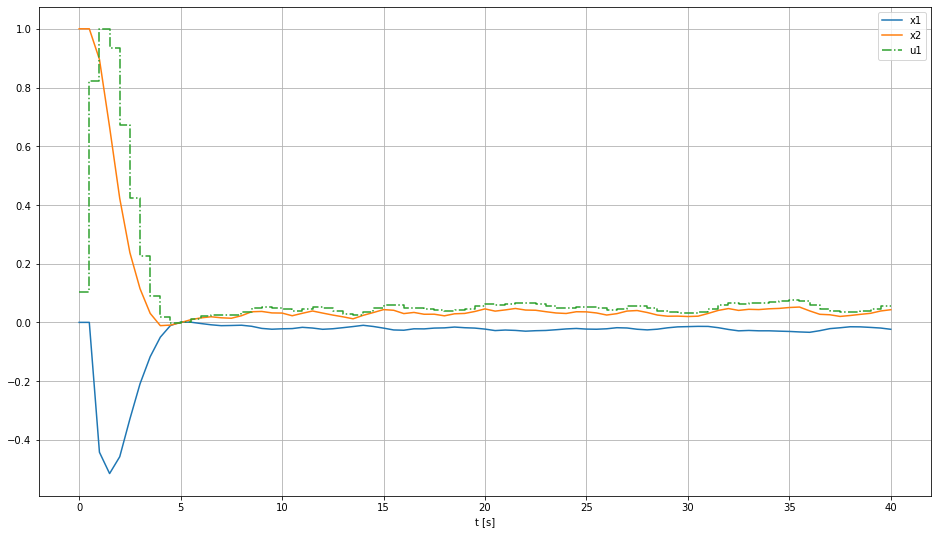

In [43]:
# Plot results!
fig = plt.figure(figsize=(16,9))
tgrid_mpc = np.linspace(0,4*T,4*N+1)
plt.plot(tgrid_mpc, np.append(x0[0], X_log[0,:]).T, label ='x1')
plt.plot(tgrid_mpc, np.append(x0[1], X_log[1,:]).T, label ='x2')
plt.plot(tgrid_mpc, np.append(U_log, np.NaN).T, linestyle='-.', drawstyle='steps-post', label="u1")
plt.xlabel('t [s]')
plt.grid(True)
plt.legend()

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [225]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x0))
print(M2(x0))

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
0.101897523198779
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
0.101897523198779
